In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

True
NVIDIA GeForce RTX 3070 Laptop GPU


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.generator = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        out = self.generator(x)

        return out

In [3]:
# Create an instance of the generator model
generator = Generator().to(device)

# Load the state dictionary of the generator model and update the generator instance
generator.load_state_dict(torch.load('./models/generator_epoch_30.pt'))
test_input = torch.rand(1,3,32,32).to(device)
print(generator(test_input).shape)

/home/david/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 3, 128, 128])


In [4]:
# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    #transforms.Grayscale(),  # add grayscale transformation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def generate_srgan_image(lr_image):
    lr_image = lr_image.convert('RGB') # convert to RGB format
    lr_tensor = transform(lr_image)
    lr_tensor = lr_tensor.to(device)
    lr_tensor = lr_tensor.unsqueeze(0)

    with torch.no_grad():
        sr_tensor = generator(lr_tensor)

    sr_tensor = sr_tensor.squeeze(0)
    sr_tensor = ((sr_tensor + 1) / 2) * 255

    # Convert the output tensor to grayscale
    sr_tensor = sr_tensor.mean(dim=0, keepdim=True)

    sr_image = transforms.ToPILImage()(sr_tensor.byte())
    return sr_image


In [5]:
from tqdm import tqdm
import os
# Define the path to the directory where the generated images will be saved
output_dir = './srgan-images/'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate and save the high-resolution images
for class_name in ['DRUSEN', 'DME']:
    for split_name in ['train', 'test']:
        data_dir = f'./Data/{split_name}/{class_name}/'
        for filename in tqdm(os.listdir(data_dir)):
            if filename.endswith('.jpeg'):
                filepath = os.path.join(data_dir, filename)
                output_path = os.path.join(output_dir, split_name, class_name, filename)
                if os.path.exists(output_path):
                    continue
                lr_image = Image.open(filepath).convert('L')  # Convert to greyscale
                sr_image = generate_srgan_image(lr_image)
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                sr_image.save(output_path)


100%|████████████████████████████████████████| 575/575 [00:03<00:00, 181.46it/s]


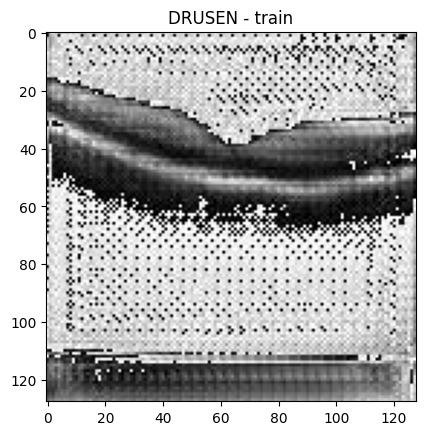

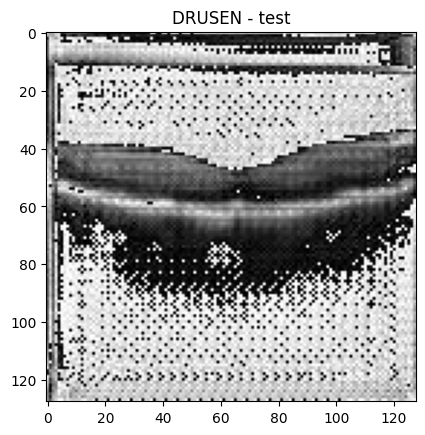

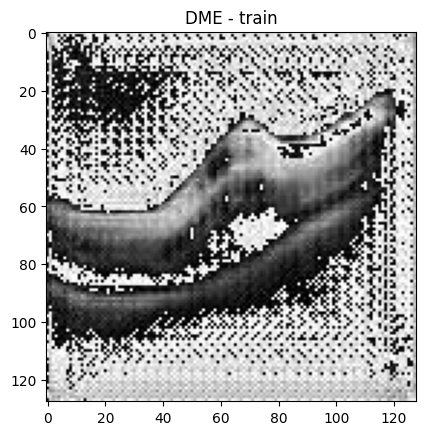

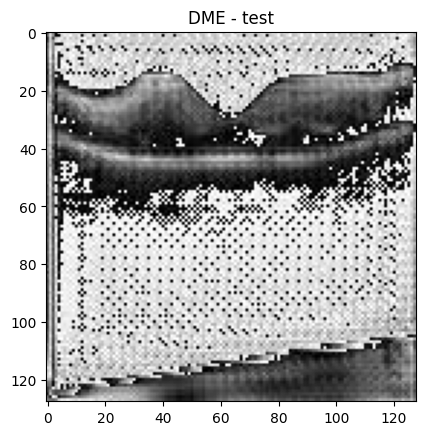

In [6]:
import matplotlib.pyplot as plt

# Define the path to the data directory
data_dir = './srgan-images/'

# Define the class names
class_names = ['DRUSEN', 'DME']

# Define the split names
split_names = ['train', 'test']

# Iterate over the class names and split names
for class_name in class_names:
    for split_name in split_names:
        # Define the path to the image directory
        image_dir = os.path.join(data_dir, split_name, class_name)
        
        # Get the list of image file paths
        image_files = os.listdir(image_dir)
        
        # Load the first image from the directory
        image_file = os.path.join(image_dir, image_files[0])
        image = Image.open(image_file).convert('L')  # convert to grayscale
        
        # Display the image
        plt.imshow(image, cmap='gray')
        plt.title(f"{class_name} - {split_name}")
        plt.show()
##############################
#i dont know why the colors are swapped, the output from the srgan code shows it properly
################################